In [1]:
%matplotlib inline

### 根据Pytorch迁移学习教程改编而得
原文地址：

http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

使用迁移学习进行猫狗识别
==========================

这个教程将教你如何使用迁移学习训练你的网络. 你可以在 cs231n 笔记中阅读更多有关迁移学习的信息.

http://cs231n.github.io/transfer-learning/

引用自该笔记,

    事实上, 很少有人从头(随机初始化)开始训练一个卷积网络, 因为拥有一个足够大的数据库是比较少见的. 替代的是, 通常会从一个大的数据集(例如 ImageNet, 包含120万的图片和1000个分类)预训练一个卷积网络, 然后将这个卷积网络作为初始化的网络, 或者是感兴趣任务的固定的特征提取器.

如下是两种主要的迁移学习的使用场景:

-  **微调卷积网络**: 取代随机初始化网络, 我们从一个预训练的网络初始化, 比如从 imagenet 1000 数据集预训练的网络. 其余的训练就像往常一样.
-  **卷积网络作为固定的特征提取器**: 在这里, 我们固定网络中的所有权重, 最后的全连接层除外. 最后的全连接层被新的随机权重替换, 并且, 只有这一层是被训练的.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------
数据集地址

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

# 比赛说明
+ 在本次比赛中，您将编写一个算法来分类图像是否包含狗或猫。这对人类，狗和猫来说很容易。你的电脑会觉得有点困难

## 特征说明
+ Dogs vs. Cats是一个传统的二分类问题。
    + 训练集包含25000张图片，命名格式为..jpg, 如cat.10000.jpg、dog.100.jpg
    + 测试集包含12500张图片，命名为.jpg，如1000.jpg。
+ 参赛者需根据训练集的图片训练模型，并在测试集上进行预测，输出它是狗的概率。
+ 最后提交的csv文件如下，第一列是图片的，第二列是图片为狗的概率。

## 数据目录结构为
+ train
  + dog
  + cat
    
+ val
  + dog
  + cat
+ test
  + test
  
其中使用train中dog和cat各2500张图像组成Val数据集

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../dogvscat/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
testdataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=4)
              for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 可视化一些图片

让我们显示一些训练中的图片, 以便了解数据增强.



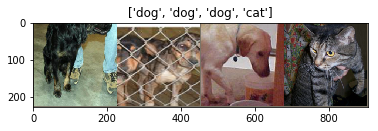

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

训练模型
------------------

现在, 让我们写一个通用的函数来训练模型. 这里, 我们将会举例说明:

-  调度学习率
-  保存最佳的学习模型

下面函数中, 参数 ``scheduler`` 是
``torch.optim.lr_scheduler`` 中的 LR scheduler 对象.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 显示模型的预测结果
写一个处理少量图片, 并显示预测结果的通用函数



In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 微调卷积网络
加载一个预训练的网络, 并重置最后一个全连接层.




In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 训练和评估
使用 GPU 的话, 需要的时间约为70分钟.




In [2]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

NameError: name 'train_model' is not defined

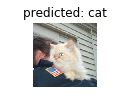

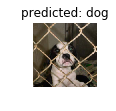

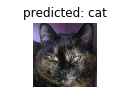

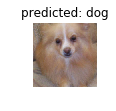

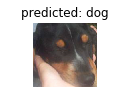

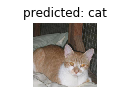

In [41]:
visualize_model(model_ft)

卷积网络作为固定的特征提取器
----------------------------------

这里, 我们固定网络中除最后一层外的所有权重. 为了固定这些参数, 我们需要设置  ``requires_grad == False`` ，然后在``backward()``中就不会计算梯度..

你可以在这里阅读更多相关信息

http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward




In [8]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 训练和评估
在使用 CPU 的情况下, 和前一个方案相比, 这将花费的时间是它的一半. 期望中, 网络的大部分是不需要计算梯度的. 前向传递依然要计算梯度.



In [59]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 

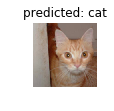

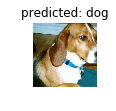

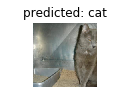

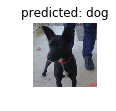

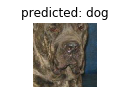

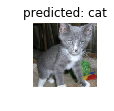

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### 测试集预测及提交

In [13]:
preds = []
for i, (inputs, labels) in enumerate(testdataloaders['test']):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_conv(inputs)
    preds.append(torch.max(outputs, 1)[1])

In [14]:
torch.save(model_conv, 'dogsvscat.pkl')

In [25]:
labels=[]
for i in range(len(preds)):
    labels.extend(preds[i].cpu().numpy())

In [33]:
fileindex = []
for i in range(12500):
    fileindex.append(testdataloaders['test'].dataset.imgs[i][0].split('\\')[-1].split('.')[0])

In [52]:
import pandas as pd

In [56]:
result = pd.Series(labels,index=fileindex)

In [57]:
result.to_csv('submit.csv')